In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Convolutions
- we inspect some basic convolutions

Image shape: torch.Size([3, 470, 700])


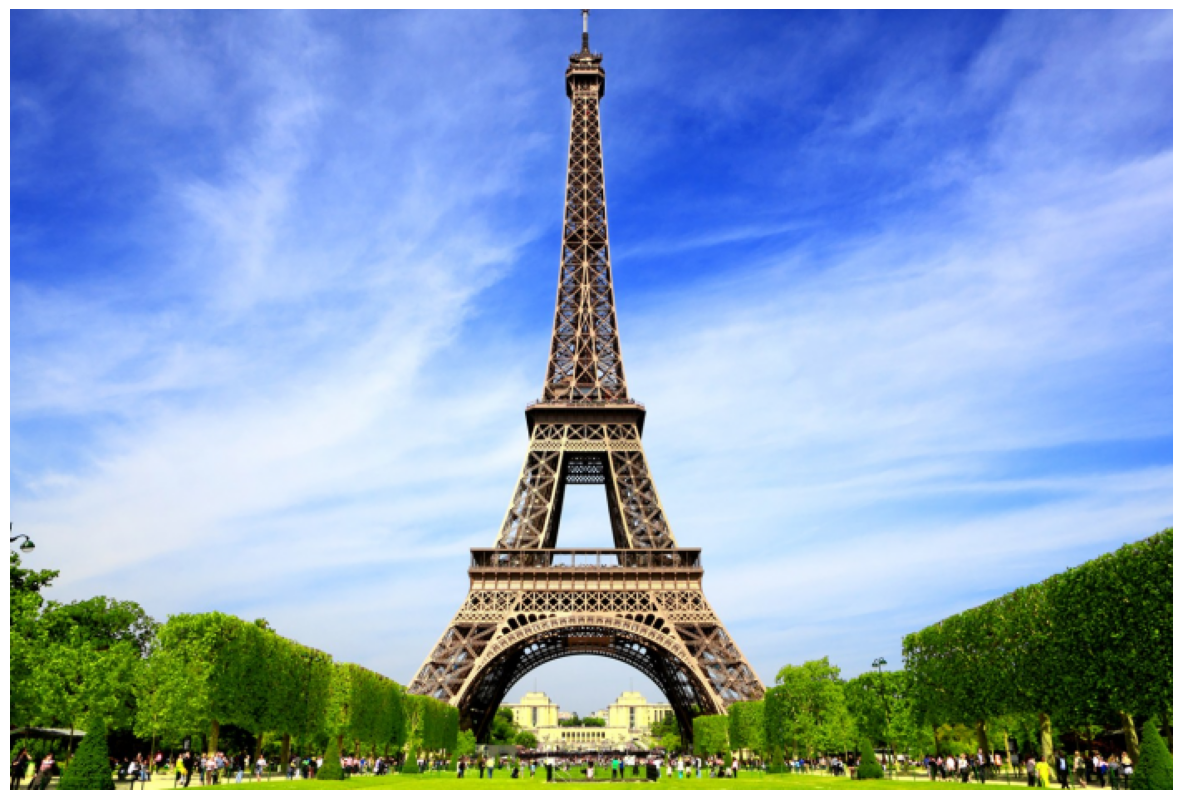

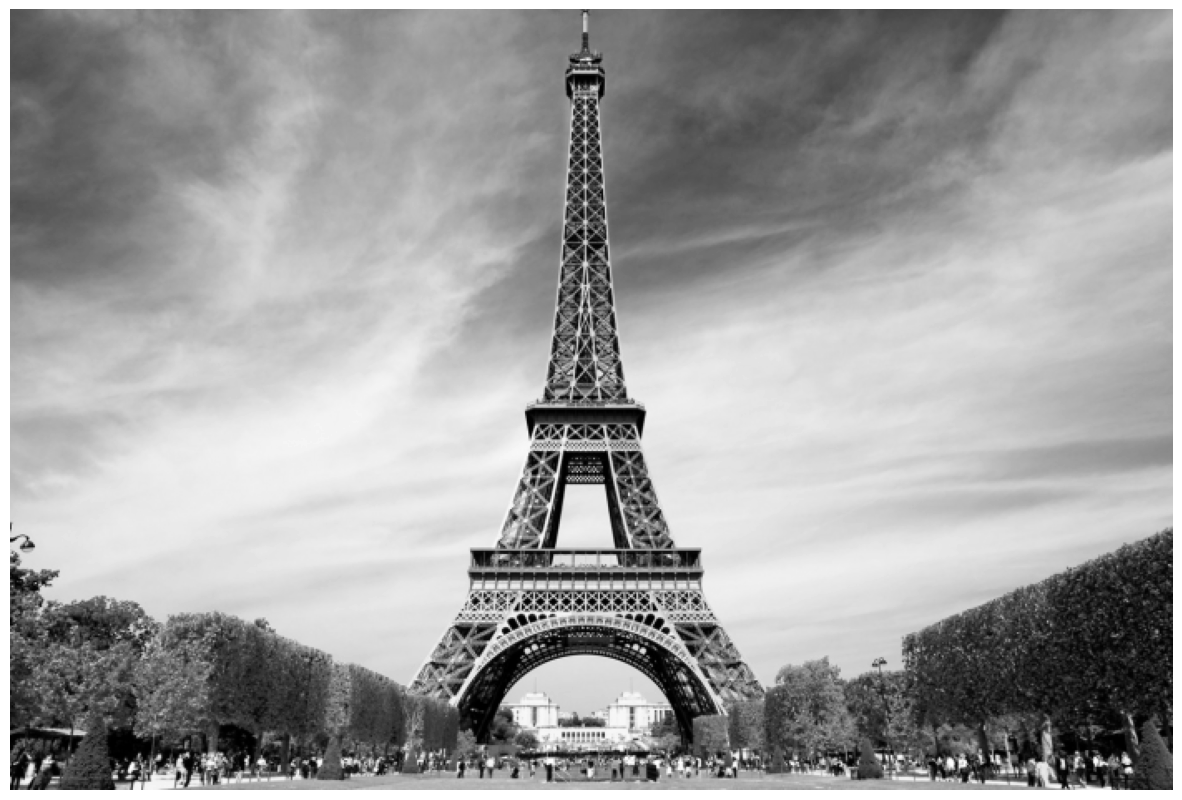

In [2]:
# Load image
img = mpimg.imread('../Data/eiffel.jpg')

# Keep only RGB channels
img = img[:, :, :3]

# Convert to torch tensor and move channels to first dimension
img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # [C, H, W]

print(f'Image shape: {img_tensor.shape}')  # Should be [3, H, W]

# Convert to grayscale using the given formula
# The weights are: Red: 0.3, Green: 0.59, Blue: 0.11
weights = torch.tensor([0.3, 0.59, 0.11]).view(3, 1, 1)
img_gray_tensor = (img_tensor * weights).sum(dim=0)  # [H, W]

# Convert to numpy for display
img_gray = img_gray_tensor.numpy()

# Plot original image
plt.figure(figsize=(15, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

# Plot grayscale image
plt.figure(figsize=(15, 12))
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.show()

In [3]:
def detect_borders(img_gray, mask, threshold=0.001):
    """
    img_gray: torch.Tensor of shape [H, W], grayscale image
    mask: torch.Tensor of shape [k, k], convolution kernel
    threshold: float, threshold to binarize the convolved result
    """
    # Ensure inputs are float tensors
    img_tensor = img_gray.unsqueeze(0).unsqueeze(0).float()  # [1, 1, H, W]
    kernel = mask.unsqueeze(0).unsqueeze(0).float()          # [1, 1, k, k]
    
    # Apply 2D convolution (no padding, no stride)
    img_processed = F.conv2d(img_tensor, kernel)
    img_processed = img_processed.squeeze(0).squeeze(0)  # [H_out, W_out]

    # Display the convolved image
    plt.figure(figsize=(15, 12))
    plt.imshow(img_processed.detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

    # Threshold and invert
    img_thresholded = 1 - (img_processed > threshold).float()

    # Display the thresholded image
    plt.figure(figsize=(15, 12))
    plt.imshow(img_thresholded.detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

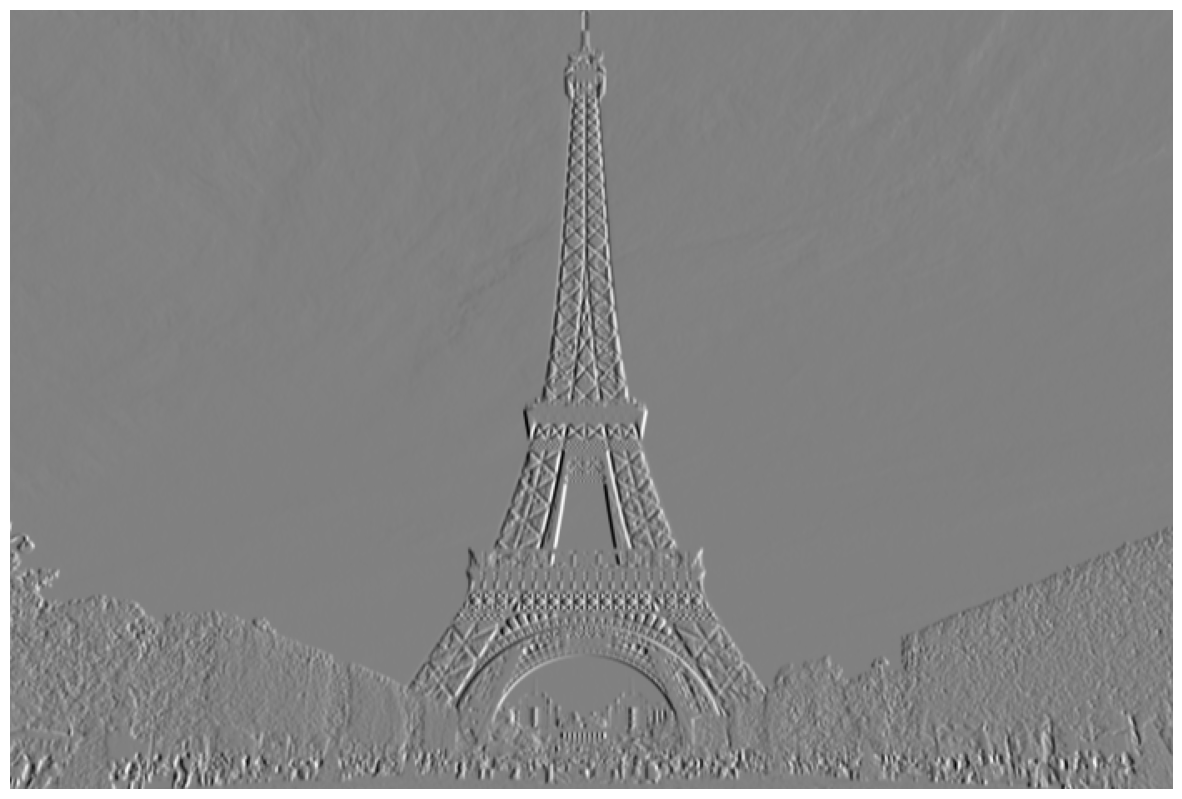

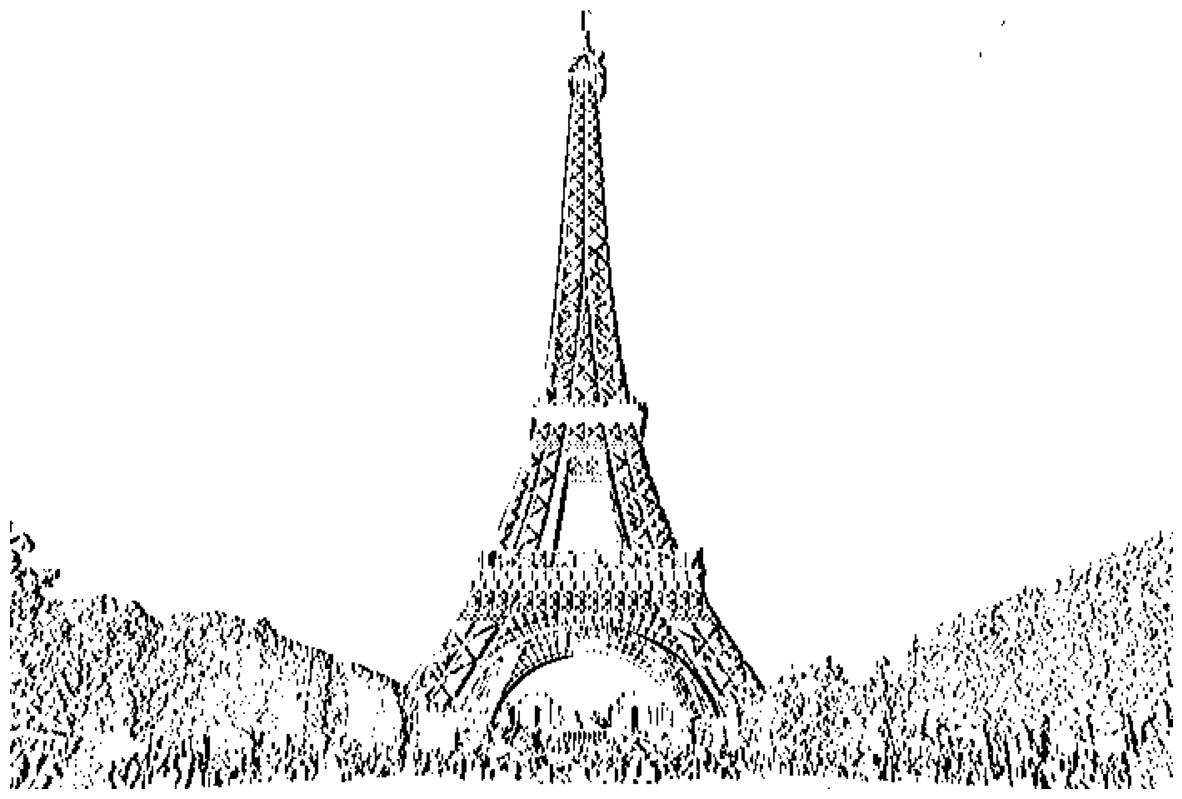

In [4]:
# Define the vertical Sobel filter as a PyTorch tensor (https://en.wikipedia.org/wiki/Sobel_operator)
mask = torch.tensor([
    [-1.,  0.,  1.],
    [-2.,  0.,  2.],
    [-1.,  0.,  1.]
])

detect_borders(img_gray_tensor, mask, threshold=0.25)

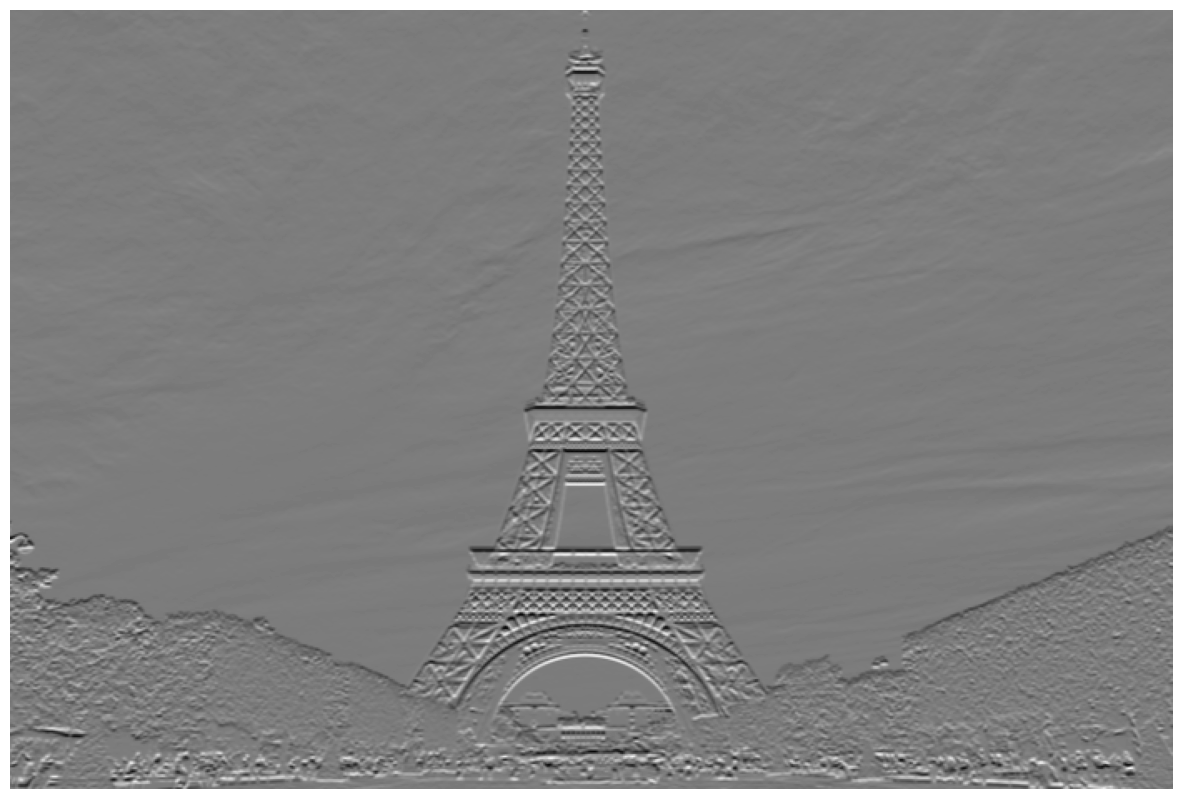

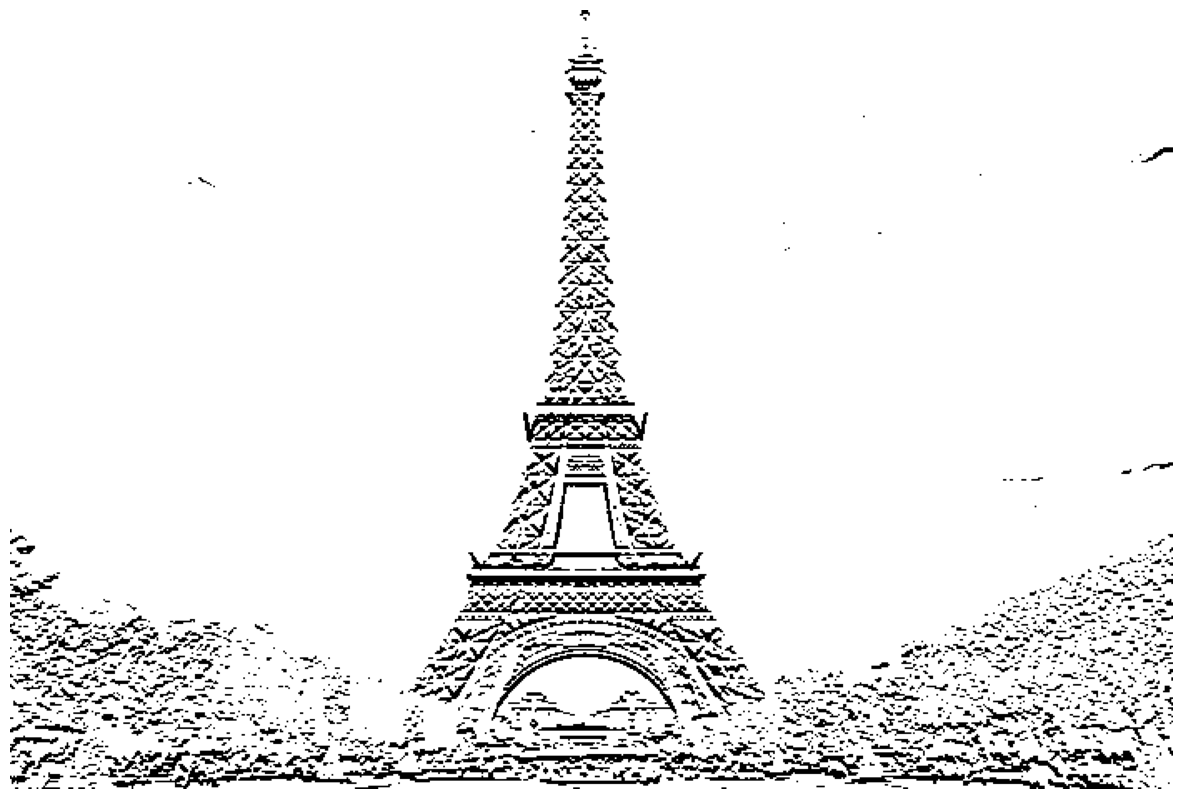

In [5]:
detect_borders(img_gray_tensor, mask.transpose(0, 1), threshold=0.25)

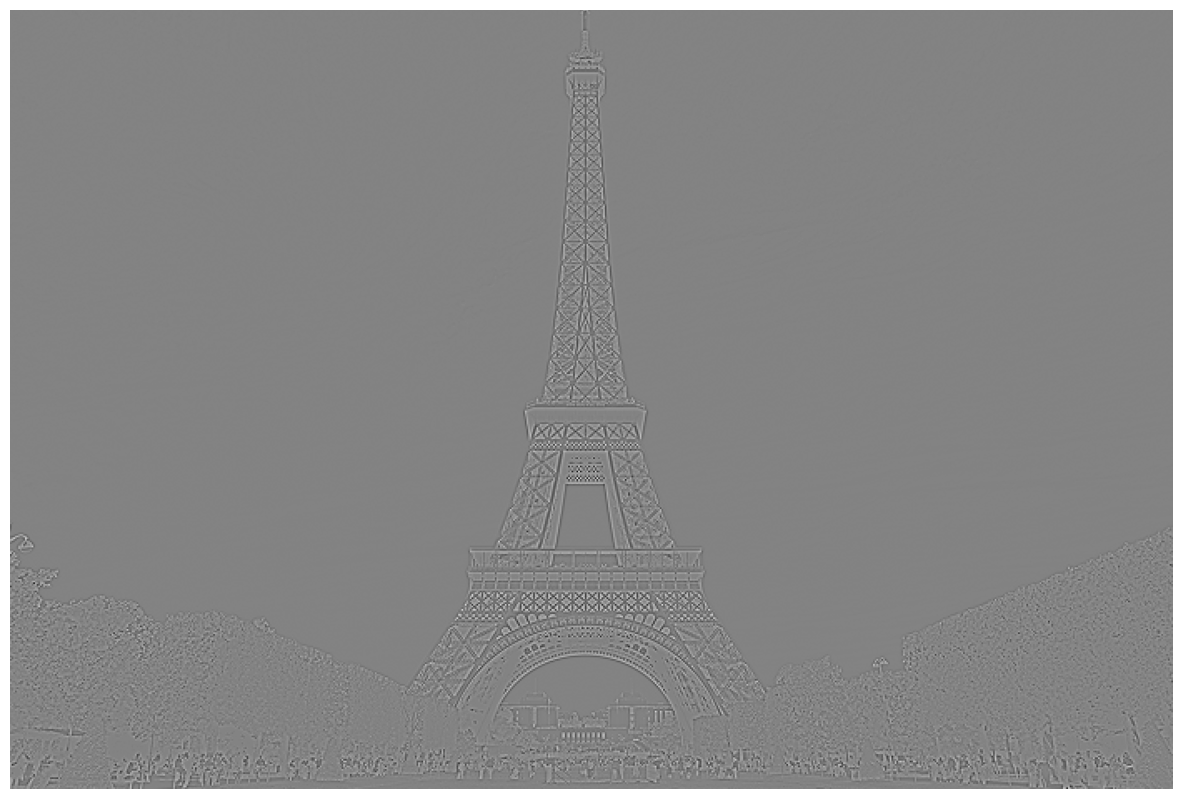

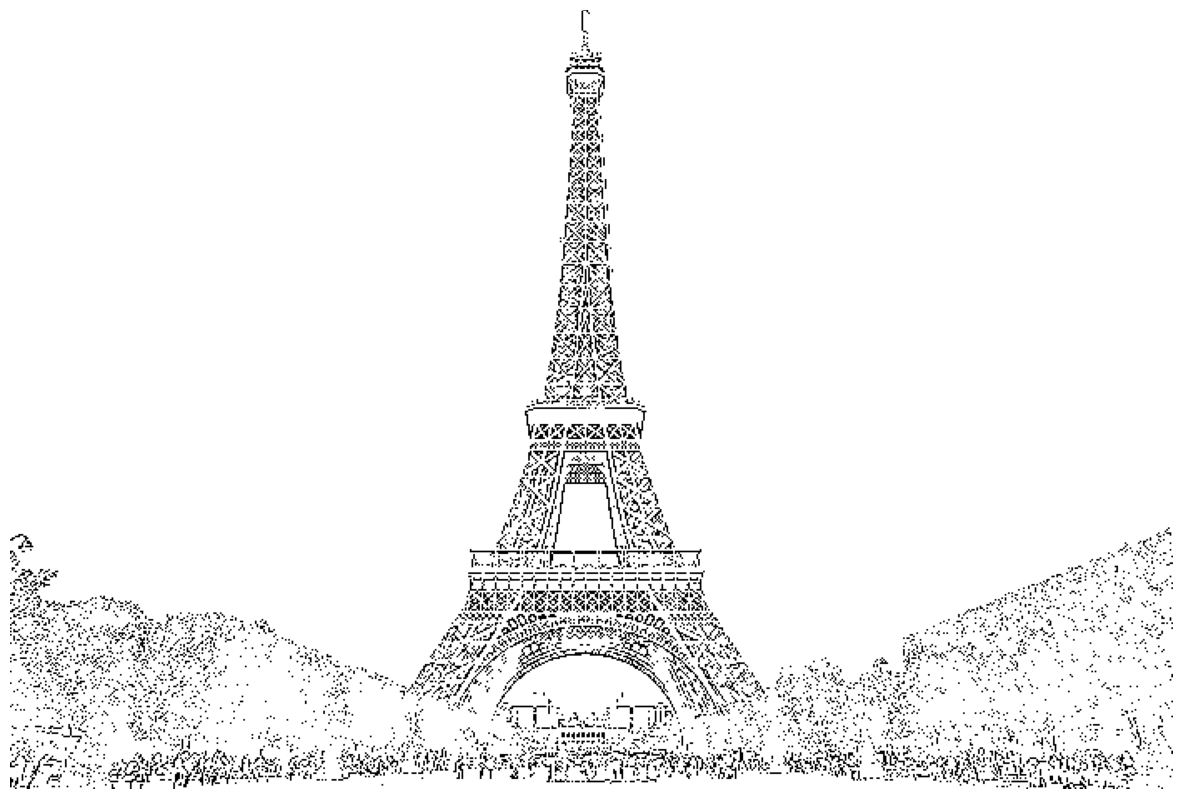

In [6]:
# Laplace edge detector, should do both horizontal and vertical
mask = torch.tensor([
    [0,  1,  0],
    [1,  -4, 1],
    [0,  1,  0]
])
detect_borders(img_gray_tensor, mask, threshold=0.25)

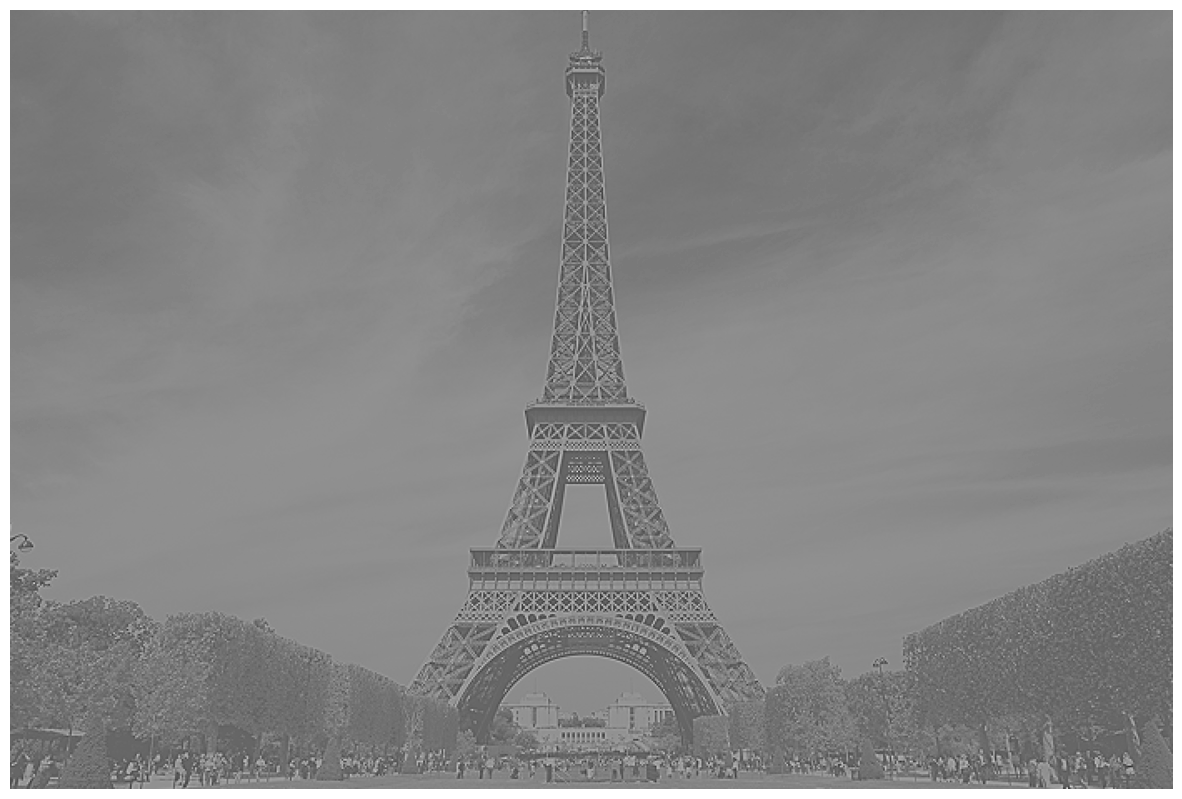

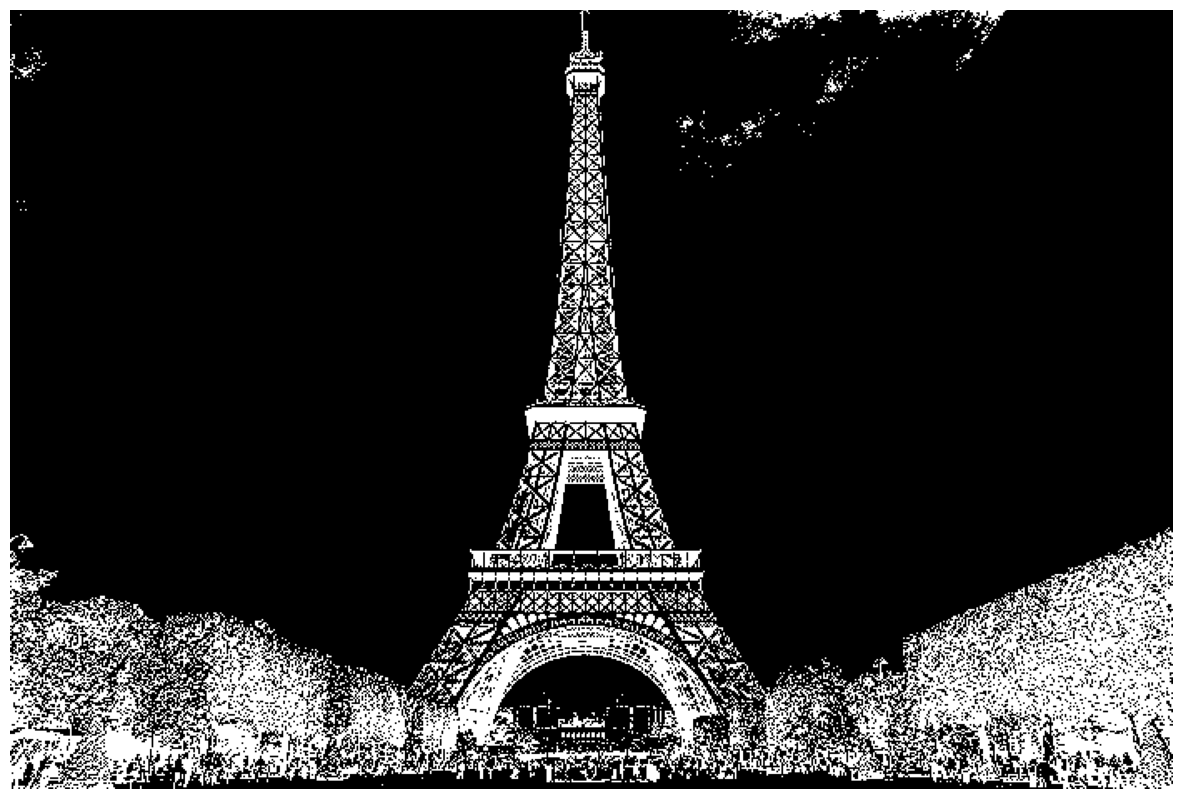

In [7]:
# now with negative sign
mask = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])
detect_borders(img_gray_tensor, mask, threshold=0.3)

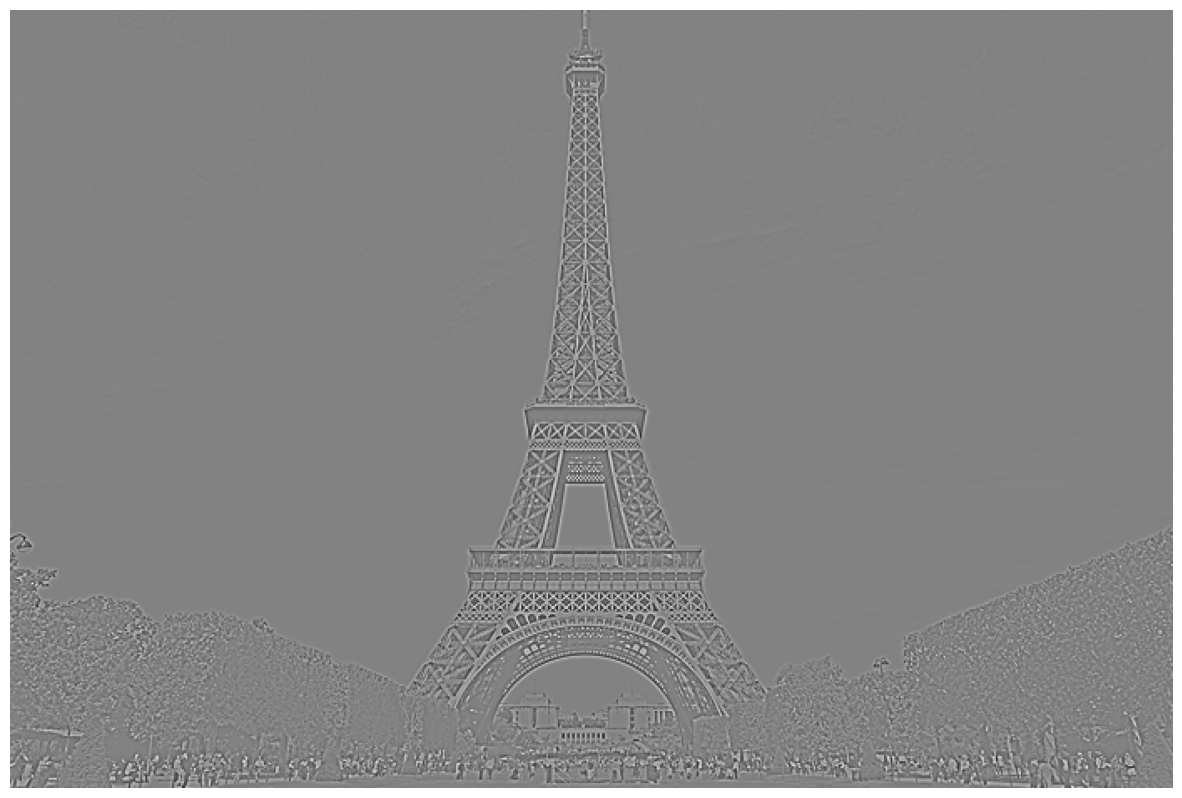

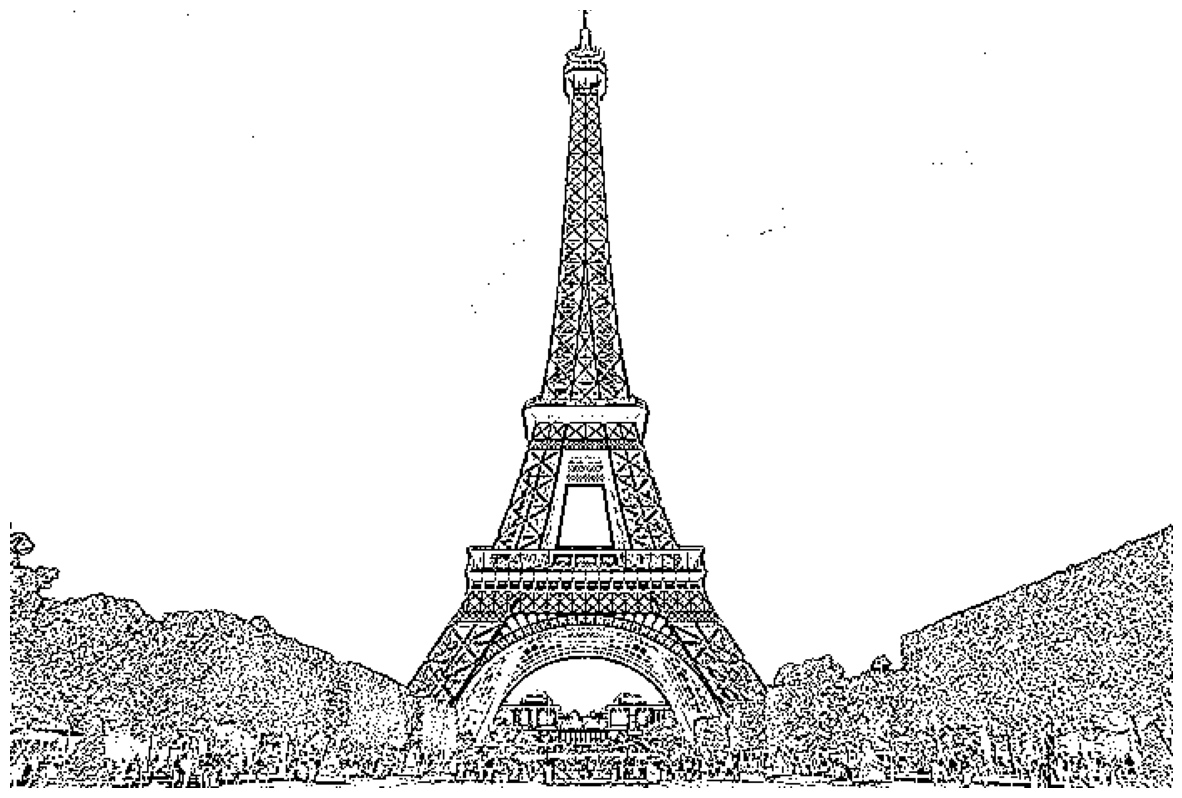

In [8]:
# Identify changes around a point
mask = torch.tensor([
    [0,   0,  -1,   0,   0],
    [0,  -1,  -2,  -1,   0],
    [-1, -2,  16,  -2,  -1],
    [0,  -1,  -2,  -1,   0],
    [0,   0,  -1,   0,   0]
])

detect_borders(img_gray_tensor, mask, threshold=0.3)

# Create dataset and dataloader
- we use MNIST 
- the dataset is downloaded (if not already present)
- data augmentation is included
- on MacOS some may encounter problem with certification when downloading the data, you can 'conda install -c conda-forge certifi' in your PyCharm Terminal and then

In [9]:
try: # disable certificate verification, needed on MacOS
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
except ImportError:
    pass  # SSL module not available, skipping workaround

In [10]:
# Define data augmentation and normalization for CIFAR-10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Resize within CIFAR-10's native size
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),  # CIFAR-10 dataset mean (RGB)
                         std=(0.2023, 0.1994, 0.2010))   # CIFAR-10 dataset std (RGB)
])

In [11]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image with label 8.


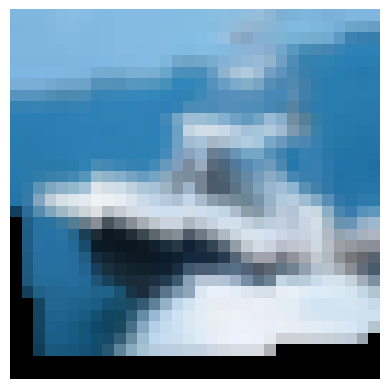

In [12]:
# Get the 11th image and its label
image, label = train_dataset[8]  # image is a tensor (3, 32, 32)
print(f'Image with label {label}.')

# Undo normalization for visualization
mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])
image = image * std[:, None, None] + mean[:, None, None]  # De-normalize

# Convert the tensor from (C, H, W) to (H, W, C)
image_tensor = image.permute(1, 2, 0)  # (H, W, C)

# Plot the image
plt.imshow(image_tensor.numpy())
plt.axis('off')
plt.show()

# Train model

- define a model as a CNN class (see below), define your own architecture using CNNs
- use regularization, optimizer, loss,... of your choice and define hyperparameters so that you obtain high accuracy

In [13]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # First convolution block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Second convolution block
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Fully connected layer
        self.fc = nn.Linear(32 * 8 * 8, 10)  # Updated for 32x32 input

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Instantiate and print summary
model = CNNModel()
print(model)

# Optional: Summary with torchsummary
try:
    from torchsummary import summary
    summary(model, input_size=(3, 32, 32))  # <- Corrected input size
except ImportError:
    print("Install torchsummary with `pip install torchsummary` to see detailed summary.")

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Install torchsummary with `pip install torchsummary` to see detailed summary.


In [14]:
class BiggerCNN(nn.Module):
    def __init__(self):
        super(BiggerCNN, self).__init__()

        # First convolution block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 32x32 -> 16x16

        # Second convolution block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 16x16 -> 8x8

        # Dropout + FC
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(64 * 8 * 8, 10)  # Updated for 32x32 input

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

# Instantiate and print model
model_bigger = BiggerCNN()
print(model_bigger)

# Optional: View model summary
try:
    from torchsummary import summary
    summary(model_bigger, input_size=(3, 32, 32))  # Updated input size for CIFAR-10
except ImportError:
    print("Install torchsummary with `pip install torchsummary` to see detailed summary.")

BiggerCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)
Install torchsummary with `pip install torchsummary` to see detailed summary.


In [15]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # First block: input (3, 32, 32) → output (16, 8, 8)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)  # 32→16
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 16→8

        # Second block: (16, 8, 8) → (32, 4, 4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 8→4

        # Third block: (32, 4, 4) → (64, 2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 4→2

        # Fourth block: (64, 2, 2) → (128, 2, 2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Global average pooling + final layers
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)

        return x

In [16]:
config = {
    "epochs": 2,
    "batch_size": 64,
    "learning_rate": 0.001,
    "weight_decay": 0.0001,
    "patience": 5,  # Early stopping patience
    "label_smoothing": 0.1,
}

# Initialize WandB
try: # disable certificate verification, needed on MacOS
    import wandb
    wandb.init(project="cifar10-cnn", config=config)
    wandb_working = True
except ImportError:
    wandb_working = False

wandb: Currently logged in as: ondrej-tybl (cvut-cmp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [17]:
# Initialize model, loss function, and optimizer
model = CustomCNN()
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

In [18]:
# Early stopping parameters
best_val_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(config['epochs']):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Track progress within the epoch
    print(f"Epoch {epoch + 1}/{config['epochs']} - Training...")
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs, labels

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress after every 100 batches (adjust as needed)
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    # Average train loss and accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"  Training Loss: {train_loss:.4f} - Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    print(f"Epoch {epoch + 1}/{config['epochs']} - Validation...")

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs, labels

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f"  Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%")

    # Log metrics to WandB
    if wandb_working:
        wandb.log({
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "epoch": epoch
        })

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= config['patience']:
            print(f"Early stopping at epoch {epoch + 1}")
            break

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

Epoch 1/2 - Training...
  Batch 0/782 - Loss: 4.9911
  Batch 100/782 - Loss: 4.1850
  Batch 200/782 - Loss: 3.5301
  Batch 300/782 - Loss: 3.7441
  Batch 400/782 - Loss: 3.2116
  Batch 500/782 - Loss: 3.0121
  Batch 600/782 - Loss: 3.1722
  Batch 700/782 - Loss: 3.0752
  Training Loss: 3.4594 - Training Accuracy: 38.36%
Epoch 1/2 - Validation...
  Validation Loss: 2.7865 - Validation Accuracy: 49.73%
Epoch 2/2 - Training...
  Batch 0/782 - Loss: 2.8866
  Batch 100/782 - Loss: 3.3521
  Batch 200/782 - Loss: 2.6125
  Batch 300/782 - Loss: 2.7035
  Batch 400/782 - Loss: 2.9220
  Batch 500/782 - Loss: 3.1918
  Batch 600/782 - Loss: 2.6980
  Batch 700/782 - Loss: 2.8133
  Training Loss: 2.8446 - Training Accuracy: 45.48%
Epoch 2/2 - Validation...
  Validation Loss: 2.3736 - Validation Accuracy: 55.02%


/var/folders/96/yn21xh3j1j110p26sflbf_sc0000gn/T/ipykernel_8956/3739377481.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.

<All keys matched successfully>

In [19]:
# Final evaluation on the validation set
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs, labels

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_loss /= len(val_loader)
val_accuracy = 100 * val_correct / val_total

print(f"Final validation loss: {val_loss:.4f}, Final validation accuracy: {val_accuracy:.2f}%")

Final validation loss: 2.3860, Final validation accuracy: 54.26%
